# Radio ML Classification - CNN Approach

Solution to the RadioML classification challenge using CNNs.

In [1]:
# Loading Data

pathToDataset = "C:/Users/aksha/Documents/Jupyter Notebooks/radioml-classification/Datasets/Standard/RML2016.10a_dict.pkl"

# Extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open(pathToDataset,'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Description of Data

The dataset has the size 220,000×2×128, which means that there are 220,000 entries, each consisting of an array of size 2 × 128. Each array represents the samples of about 128 µs of a received waveform sampled with approximately 106 samples/second, and it contains between 8 and 16 modulation symbols. Since the samples of the signal waveforms are complex-valued, they have been stored as real and imaginary parts, and therefore we have arrays of size 2 × 128 in the data set.

That is, each row is essentially, **a + ib**.

The labels of the downloaded dataset contain two parameters: the modulation technique used (one of [’8PSK’, ’AM-DSB’, ’AM-SSB’, ’BPSK’,’CPFSK’, ’GFSK’, ’PAM4’, ’QAM16’, ’QAM64’, ’QPSK’, ’WBFM’], so 11 possible modulation techniques), and the signal-to noise ratio (SNR) value (one of [−20, −18, −16, −14, −12, −10, −8, −6, −4, −2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18], so 20 possible SNR values). The SNR is a measure for the quality of the communication channel. The higher the SNR, the less “noisy” is the channel.

Each item of the list is essentially like **(b'Modulation Type',SNR Value)** [Use os.fsdecode to extract Modulation Type as string] 

In [2]:
# Import Necessary Packages
%matplotlib inline
import os
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, LayerNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import numpy as np

# Data Processing

The goal of this stage is to split data into Training, Validation and Testing data and then process the available data and transform (if needed) it into relevant inputs to be fed into the CNN.

1. Split Dataset into Training, Validation and Testing Data : 110,000 samples for training and validation and 110,000 samples for testing.

In [3]:
#  into training and test sets of the form we can train/test on 
np.random.seed(777)

index = np.arange(0,220000)
random.shuffle(index)

trainIdx = index[0:110000]
testIdx = index[110000:220000]

trainX = X[trainIdx]
X_train = np.expand_dims(trainX, axis=-1) # Important

testX = X[testIdx]
X_test = np.expand_dims(testX, axis=-1) # Important

In [4]:
# One Hot Encode Labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[trainIdx]
y_test=lbl_encoded[testIdx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


# Design Neural Network

In [11]:
# Network Parameters
dropoutRate = 0.6

# Structure
inpShape = (2,128,1) # Shape of Input Data
CNN1_numFilt = 256 # Number of Filters in CNN Layer 1
CNN1_kernSize = (1,3) # Kernel Size of CNN Layer 1

CNN2_numFilt = 80 # Number of Filters in CNN Layer 2
CNN2_kernSize = (2,3) # Kernel Size of CNN Layer 2

Dense1_numNeurons = 256 # Number of Nodes in the First Dense Layer
numOutput = 11 # Number of Output Nodes

# Weight Initialization
weightInit = 'glorot_uniform' # Xavier Initialization

# Activation Functions
activationHidden = 'relu'
activationOutput = 'softmax'

# Loss Function
lossFunction = 'categorical_crossentropy'

# Learning Algorithm
netOptimizer = 'adam'

# Callbacks
callbackList = [
        tensorflow.keras.callbacks.ModelCheckpoint('cnnWeights_best.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')]

# Construct Network
model = models.Sequential()
model.add(BatchNormalization(axis=-1,input_shape=inpShape, name='Normalization_1'))
model.add(ZeroPadding2D(padding=(0,1),name='ZPad1'))
model.add(Convolution2D(filters=CNN1_numFilt, kernel_size=CNN1_kernSize, activation=activationHidden, name='Conv_1'))
model.add(Dropout(dropoutRate))
model.add(ZeroPadding2D(padding=(1,1),input_shape=inpShape,name='ZPad2'))
model.add(Convolution2D(filters=CNN2_numFilt, kernel_size=CNN2_kernSize, activation=activationHidden, name='Conv_2'))
model.add(Dropout(dropoutRate))
model.add(Flatten())
model.add(Dense(Dense1_numNeurons, activation=activationHidden))
model.add(Dropout(dropoutRate))
model.add(Dense(numOutput, activation=activationOutput))
model.compile(loss=lossFunction, optimizer=netOptimizer,metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normalization_1 (BatchNormal (None, 2, 128, 1)         4         
_________________________________________________________________
ZPad1 (ZeroPadding2D)        (None, 2, 130, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 2, 128, 256)       1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 128, 256)       0         
_________________________________________________________________
ZPad2 (ZeroPadding2D)        (None, 4, 130, 256)       0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 3, 128, 80)        122960    
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 128, 80)       

# Train Network

In [8]:
numEpochs = 100
batchSize = 1024

In [12]:
history = model.fit(X_train,y_train,epochs=numEpochs,batch_size=batchSize,validation_split=0.1,callbacks=callbackList,verbose=2)

Train on 99000 samples, validate on 11000 samples
Epoch 1/100
99000/99000 - 34s - loss: 2.0385 - categorical_accuracy: 0.2503 - val_loss: 2.3836 - val_categorical_accuracy: 0.1373
Epoch 2/100
99000/99000 - 30s - loss: 1.8080 - categorical_accuracy: 0.3195 - val_loss: 2.3660 - val_categorical_accuracy: 0.1165
Epoch 3/100
99000/99000 - 31s - loss: 1.5753 - categorical_accuracy: 0.4055 - val_loss: 2.3810 - val_categorical_accuracy: 0.1152
Epoch 4/100
99000/99000 - 31s - loss: 1.4757 - categorical_accuracy: 0.4368 - val_loss: 2.2425 - val_categorical_accuracy: 0.1841
Epoch 5/100
99000/99000 - 31s - loss: 1.4326 - categorical_accuracy: 0.4526 - val_loss: 2.2652 - val_categorical_accuracy: 0.2341
Epoch 6/100
99000/99000 - 31s - loss: 1.4035 - categorical_accuracy: 0.4632 - val_loss: 2.3552 - val_categorical_accuracy: 0.2577
Epoch 7/100
99000/99000 - 36s - loss: 1.3793 - categorical_accuracy: 0.4733 - val_loss: 2.5123 - val_categorical_accuracy: 0.2721
Epoch 8/100
99000/99000 - 38s - loss: 1.

# Test/Evaluate Network

In [13]:
# Re-load Best Weights
model.load_weights('cnnWeights_best.h5')

model.evaluate(X_test,y_test)

110000/110000 [==============================] - 18s 162us/sample - loss: 1.2625 - categorical_accuracy: 0.5230


[1.262458514438976, 0.52300906]

# Visualize Results

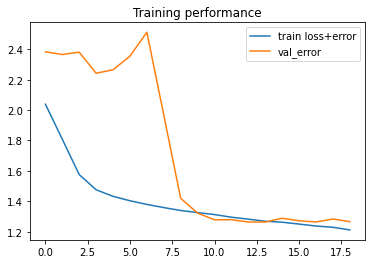

In [14]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [15]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

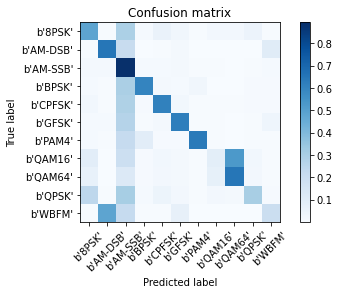

In [17]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=1000)
conf = np.zeros([len(mods),len(mods)])
confnorm = np.zeros([len(mods),len(mods)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(mods)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=mods)

In [18]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[testIdx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.09363636363636364 for SNR b'-20'
Overall Accuracy:  0.09599561162918267 for SNR b'-18'
Overall Accuracy:  0.10134512622074811 for SNR b'-16'
Overall Accuracy:  0.10780532598714417 for SNR b'-14'
Overall Accuracy:  0.1434854315557999 for SNR b'-12'
Overall Accuracy:  0.230571376079368 for SNR b'-10'
Overall Accuracy:  0.3302600036879956 for SNR b'-8'
Overall Accuracy:  0.47662876737051074 for SNR b'-6'
Overall Accuracy:  0.6058707714336854 for SNR b'-4'
Overall Accuracy:  0.684143455306754 for SNR b'-2'
Overall Accuracy:  0.7320273184759166 for SNR b'0'
Overall Accuracy:  0.7550983248361253 for SNR b'2'
Overall Accuracy:  0.7504939823962637 for SNR b'4'
Overall Accuracy:  0.7545754026354319 for SNR b'6'
Overall Accuracy:  0.7638640429338104 for SNR b'8'
Overall Accuracy:  0.7673830594184576 for SNR b'10'
Overall Accuracy:  0.7584576209530739 for SNR b'12'
Overall Accuracy:  0.7583819241982507 for SNR b'14'
Overall Accuracy:  0.755744526868102 for SNR b'16'
Overall A

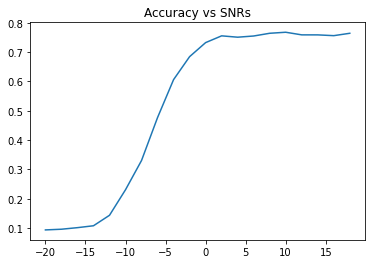

In [19]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.plot(np.arange(-20,20,2), acc_array)